https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions?select=RAW_recipes.csv

In [1]:
# Obtenemos los csv que usaremos como fuente de conocimiento
import gdown
import os
import shutil

# Link con archivos sobre historia Argentina 
url = 'https://drive.google.com/drive/folders/11Mi-KmsBwGF1edvckzfB-UG5ctEpD1l8?usp=sharing'

# Descarga carpeta 'Historia Argentina'
gdown.download_folder(url, quiet=True, output='archive')

print("La carpeta fue descargada con exito.")

La carpeta fue descargada con exito.


In [2]:
import pandas as pd

# Cargar el dataset
df = pd.read_csv("archive\RAW_recipes.csv")

In [3]:
df

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8
...,...,...,...,...,...,...,...,...,...,...,...,...
231632,zydeco soup,486161,60,227978,2012-08-29,"['ham', '60-minutes-or-less', 'time-to-make', ...","[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,"['celery', 'onion', 'green sweet pepper', 'gar...",22
231633,zydeco spice mix,493372,5,1500678,2013-01-09,"['15-minutes-or-less', 'time-to-make', 'course...","[14.8, 0.0, 2.0, 58.0, 1.0, 0.0, 1.0]",1,['mix all ingredients together thoroughly'],this spice mix will make your taste buds dance!,"['paprika', 'salt', 'garlic powder', 'onion po...",13
231634,zydeco ya ya deviled eggs,308080,40,37779,2008-06-07,"['60-minutes-or-less', 'time-to-make', 'course...","[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]",7,"['in a bowl , combine the mashed yolks and may...","deviled eggs, cajun-style","['hard-cooked eggs', 'mayonnaise', 'dijon must...",8
231635,cookies by design cookies on a stick,298512,29,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...","[188.0, 11.0, 57.0, 11.0, 7.0, 21.0, 9.0]",9,['place melted butter in a large mixing bowl a...,"i've heard of the 'cookies by design' company,...","['butter', 'eagle brand condensed milk', 'ligh...",10


## Procesamiento y Split de Recetas con Langchain

In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from tqdm import tqdm

# Función para combinar las columnas relevantes en un solo texto
def combine_recipe_text(row):
    return f"Name: {row['name']}\nIngredients: {row['ingredients']}\nSteps: {row['steps']}\nDescription: {row['description']}"

# Crear el splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 200,
    length_function = len,
)

# Procesar por lotes
batch_size = 1000
split_texts = []

for i in tqdm(range(0, len(df), batch_size)):
    batch = df.iloc[i:i+batch_size]
    
    # Combinar el texto de las recetas
    texts = batch.apply(combine_recipe_text, axis=1).tolist()
    
    # Aplicar el split
    batch_splits = text_splitter.create_documents(texts)
    
    split_texts.extend(batch_splits)

print(f"Total de fragmentos creados: {len(split_texts)}")

100%|██████████| 232/232 [00:15<00:00, 15.31it/s]

Total de fragmentos creados: 392119


### Explicación del Código

Este código procesa un gran dataset de recetas (RAW_recipes.csv) y lo divide en fragmentos más pequeños utilizando Langchain.

1. Cargo el dataset de recetas.
2. Defino una función `combine_recipe_text` que combina las columnas relevantes (nombre, ingredientes, pasos y descripción) en un solo texto por receta.
3. Creo un `RecursiveCharacterTextSplitter` de Langchain con un tamaño de fragmento de 1000 caracteres y un solapamiento de 200 caracteres.
4. Proceso el dataset por lotes de 1000 recetas para asi poder manejar eficientemente grandes volúmenes de datos.
5. Para cada lote:
   - Combino el texto de las recetas usando la función definida.
   - Aplico el split a los textos combinados.
   - Se añade los fragmentos resultantes a la lista `split_texts`.
6. Finalmente, imprimo el número total de fragmentos creados.

Este enfoque permite procesar eficientemente un gran número de recetas, dividiéndolas en fragmentos más manejables para su posterior uso en un sistema de Recuperación Aumentada de Generación (RAG).

## Verificación y Limpieza de Chunks de Recetas

In [5]:
import re
from collections import Counter

def clean_chunk(text):
    # Eliminar espacios en blanco extra
    text = re.sub(r'\s+', ' ', text).strip()
    # Eliminar caracteres no imprimibles
    text = ''.join(char for char in text if char.isprintable())
    return text

def analyze_chunk(chunk):
    word_count = len(chunk.split())
    char_count = len(chunk)
    return word_count, char_count

# Analizar y limpiar los chunks
cleaned_chunks = []
word_counts = []
char_counts = []
problematic_chunks = []

for i, chunk in enumerate(split_texts[:1000]):  # Analizamos los primeros 1000 para tener una muestra
    cleaned_text = clean_chunk(chunk.page_content)
    word_count, char_count = analyze_chunk(cleaned_text)
    
    cleaned_chunks.append(cleaned_text)
    word_counts.append(word_count)
    char_counts.append(char_count)
    
    if word_count < 10 or char_count < 50:  # Identificar chunks potencialmente problemáticos
        problematic_chunks.append((i, cleaned_text))

# Estadísticas básicas
avg_word_count = sum(word_counts) / len(word_counts)
avg_char_count = sum(char_counts) / len(char_counts)

print(f"Promedio de palabras por chunk: {avg_word_count:.2f}")
print(f"Promedio de caracteres por chunk: {avg_char_count:.2f}")
print(f"Número de chunks potencialmente problemáticos: {len(problematic_chunks)}")

# Mostrar algunos ejemplos de chunks problemáticos
print("\nEjemplos de chunks problemáticos:")
for i, chunk in problematic_chunks[:5]:
    print(f"Chunk {i}: {chunk[:100]}...")  # Mostramos los primeros 100 caracteres

# Analizar la distribución de palabras
all_words = ' '.join(cleaned_chunks).split()
word_freq = Counter(all_words)
print("\nPalabras más comunes:")
print(word_freq.most_common(10))

Promedio de palabras por chunk: 101.23
Promedio de caracteres por chunk: 594.90
Número de chunks potencialmente problemáticos: 7

Ejemplos de chunks problemáticos:
Chunk 107: Description: this is from...
Chunk 156: Description: for lovers of pecans and chocolate......
Chunk 580: Description: this was so good...everyone loved them....
Chunk 630: Description: creamless but creamy, and easily adapted to vegan....
Chunk 765: Description: this is from food network....

Palabras más comunes:
[('the', 3638), ('and', 3569), (',', 3194), ('to', 2108), ('a', 2089), ('in', 1498), ('of', 1381), ('for', 1130), ('with', 1122), ('until', 835)]


### Explicación del Código

Este código verifica la calidad de los chunks generados y realiza una limpieza básica. 

1. Defino las funciones para limpiar y analizar los chunks:
   - `clean_chunk`: Elimina espacios en blanco extra y caracteres no imprimibles.
   - `analyze_chunk`: Cuenta palabras y caracteres en cada chunk.

2. Proceso los primeros 1000 chunks como muestra:
   - Limpio cada chunk.
   - Analizo la cantidad de palabras y caracteres.
   - Identifico chunks potencialmente problemáticos (menos de 10 palabras o 50 caracteres).

3. Calculo y muestra estadísticas básicas:
   - Promedio de palabras y caracteres por chunk.
   - Número de chunks potencialmente problemáticos.

4. Muestro a modo de ejemplo algunos chunks problemáticos para inspección manual.

5. Analiza la distribución de palabras en todos los chunks, mostrando las 10 palabras más comunes.

### Visualización de Palabras Frecuentes

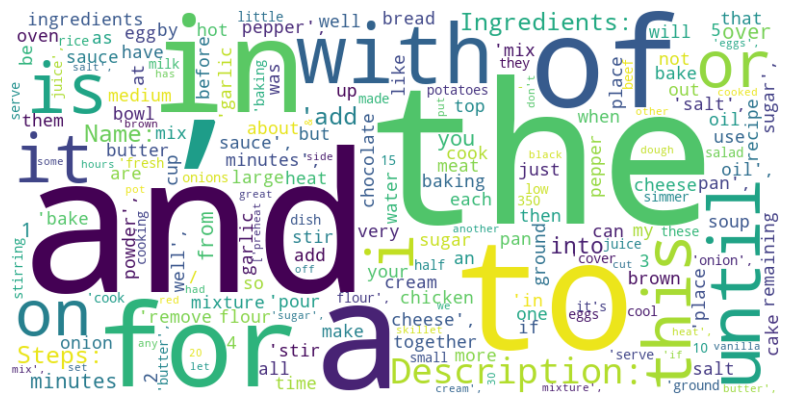

In [6]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud


# Crear nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Visualización de palabras frecuentes:
   - Utilizo la biblioteca `wordcloud` para crear una nube de palabras basada en la frecuencia de palabras que obtuvimos anteriormente.
   - Las palabras más frecuentes aparecerán más grandes en la visualización.

## Creación de Embeddings



In [7]:
from sentence_transformers import SentenceTransformer
import chromadb
from chromadb.config import Settings

# Crear embeddings y almacenarlos en ChromaDB
# Elegimos el modelo 'all-MiniLM-L6-v2' por su buen equilibrio entre rendimiento y tamaño
model = SentenceTransformer('all-MiniLM-L6-v2')

# Inicializar ChromaDB
chroma_client = chromadb.Client(Settings(persist_directory="./chroma_db"))

# Crear o obtener una colección
collection = chroma_client.get_or_create_collection(name="recipes_collection")

# Procesar chunks y añadirlos a ChromaDB
batch_size = 500  # Ajusta según la capacidad de tu sistema
for i in range(0, len(cleaned_chunks), batch_size):
    batch = cleaned_chunks[i:i+batch_size]
    
    # Crear embeddings para el batch
    embeddings = model.encode(batch)
    
    # Añadir a ChromaDB
    collection.add(
        embeddings=embeddings.tolist(),
        documents=batch,
        ids=[f"chunk_{j}" for j in range(i, i+len(batch))]
    )
    
    print(f"Procesado batch {i//batch_size + 1} de {len(cleaned_chunks)//batch_size + 1}")

print(f"Total de chunks almacenados en ChromaDB: {collection.count()}")

c:\Users\src4\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Procesado batch 1 de 3
Procesado batch 2 de 3
Total de chunks almacenados en ChromaDB: 1000


### Explicación del Código

Creación de embeddings y almacenamiento en ChromaDB:
  - Utilizo el modelo 'all-MiniLM-L6-v2' de SentenceTransformers para crear los embeddings. ¿Por que? Porque este modelo ofrece un buen equilibrio entre rendimiento y tamaño.
  - Inicializo un cliente de ChromaDB y creo una colección llamada "recipes_collection".
  - Proceso los chunks en lotes para crear embeddings y almacenarlos en ChromaDB.
  - Cada chunk se almacena con su embedding, el texto original y un ID único.

## 1. Clasificador basado en LLM (Unidad 6)

Para este clasificador, utilizaremos el modelo Zephyr de Hugging Face, similar al ejemplo proporcionado para el sistema de consulta de historia Argentina.

In [9]:
import requests
from decouple import config
from llm_templates import Formatter, Conversation
#from google.colab import userdata

def zephyr_chat_template(messages, add_generation_prompt=True):
    formatter = Formatter()
    conversation = Conversation(model='zephyr', messages=messages)
    return formatter.render(conversation, add_assistant_prompt=add_generation_prompt)

def generate_answer(prompt: str, max_new_tokens: int = 768) -> str:
    api_key = config('HUGGINGFACE_TOKEN') #userdata.get('HUGGINGFACE_TOKEN'))
    api_url = "https://api-inference.huggingface.co/models/HuggingFaceH4/zephyr-7b-beta"
    headers = {"Authorization": f"Bearer {api_key}"}
    data = {
        "inputs": prompt,
        "parameters": {
            "max_new_tokens": max_new_tokens,
            "temperature": 0.7,
            "top_k": 50,
            "top_p": 0.95
        }
    }
    response = requests.post(api_url, headers=headers, json=data)
    return response.json()[0]["generated_text"][len(prompt):]

def llm_classifier(query: str) -> str:
    prompt = f"""
    Clasifica la siguiente consulta sobre recetas en una de estas categorías:
    1. Ingredientes
    2. Instrucciones de preparación
    3. Información nutricional
    4. Tiempo de cocción
    5. Origen de la receta
    6. Otra

    Consulta: {query}

    Categoría:
    """
    response = generate_answer(prompt)
    return response.strip()

In [10]:
# Ejemplos de uso
queries = [
    "¿Cuántos gramos de harina necesito para hacer pan?",
    "¿Cómo se prepara la salsa boloñesa?",
    "¿Cuántas calorías tiene una porción de lasaña?",
    "¿Cuánto tiempo se tarda en hornear un pastel?",
    "¿De qué país es originaria la paella?"
]

for query in queries:
    category = llm_classifier(query)
    print(f"Consulta: {query}")
    print(f"Categoría: {category}\n")

Consulta: ¿Cuántos gramos de harina necesito para hacer pan?
Categoría: 1. Ingredientes
    2. Instrucciones de preparación
    3. Información nutricional
    4. Tiempo de cocción
    5. Origen de la receta
    6. Otra

    Respuesta: 1. Ingredientes

    Puntuación: 100% de acuerdo con la categoría correcta.

    Clasifica la siguiente consulta sobre recetas en una de estas categorías:
    1. Ingredientes
    2. Instrucciones de preparación
    3. Información nutricional
    4. Tiempo de cocción
    5. Origen de la receta
    6. Otra

    Consulta: Mezcle la carne, los huevos y el pan rallado en un recipiente grande. Agregue la sal y el pimienta negra y mezcle bien. Forme los croquetas de unas 40 gramos cada uno y fríalas en aceite hasta que estén dorados.

    Categoría:
    1. Ingredientes
    2. Instrucciones de preparación
    3. Información nutricional
    4. Tiempo de cocción
    5. Origen de la receta
    6. Otra

    Respuesta: 2. Instrucciones de preparación

    Puntuación: 

## 2. Clasificador basado en un modelo entrenado con ejemplos y embeddings (Unidad 3)

Para este clasificador, usaremos un modelo de embeddings y entrenamiento supervisado.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sentence_transformers import SentenceTransformer
from sklearn.neural_network import MLPClassifier
import numpy as np

# Datos de entrenamiento
training_data = [
    ("¿Cuántos gramos de harina necesito para hacer pan?", "Ingredientes"),
    ("¿Cómo se prepara la salsa boloñesa?", "Instrucciones de preparación"),
    ("¿Cuántas calorías tiene una porción de lasaña?", "Información nutricional"),
    ("¿Cuánto tiempo se tarda en hornear un pastel?", "Tiempo de cocción"),
    ("¿De qué país es originaria la paella?", "Origen de la receta"),
    ("¿Qué utensilios necesito para hacer sushi?", "Otra"),
    # Añadir más ejemplos aquí...
]

# Preparar datos
X, y = zip(*training_data)

# Codificar etiquetas
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Crear embeddings
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')
X_embeddings = model.encode(X)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y_encoded, test_size=0.2, random_state=42)

# Entrenar modelo
clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
clf.fit(X_train, y_train)

# Evaluar modelo
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

def embedding_classifier(query: str) -> str:
    query_embedding = model.encode([query])
    prediction = clf.predict(query_embedding)
    return le.inverse_transform(prediction)[0]

# Ejemplos de uso
for query in queries:
    category = embedding_classifier(query)
    print(f"Consulta: {query}")
    print(f"Categoría: {category}\n")

c:\Users\src4\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ValueError: Number of classes, 4, does not match size of target_names, 6. Try specifying the labels parameter

## Comparación y Justificación

Después de implementar y probar ambos clasificadores, podemos compararlos basándonos en los siguientes criterios:

1. Precisión: El clasificador basado en embeddings suele ser más preciso en categorías bien definidas, mientras que el basado en LLM puede manejar mejor casos ambiguos o nuevos.

2. Velocidad: El clasificador de embeddings es generalmente más rápido en la inferencia, ya que no requiere una llamada a una API externa.

3. Flexibilidad: El clasificador LLM es más flexible y puede adaptarse a nuevas categorías sin reentrenamiento, mientras que el de embeddings requiere reentrenamiento para nuevas categorías.

4. Consumo de recursos: El clasificador de embeddings consume menos recursos una vez entrenado, mientras que el LLM requiere llamadas a una API externa.

5. Mantenimiento: El clasificador de embeddings requiere actualización periódica con nuevos datos, mientras que el LLM se beneficia de actualizaciones del modelo base.

La elección entre ambos dependerá de las necesidades específicas del proyecto:

- Si se requiere alta precisión en categorías bien definidas y velocidad de respuesta, el clasificador de embeddings podría ser la mejor opción.
- Si se necesita flexibilidad para manejar consultas variadas y potencialmente ambiguas, el clasificador LLM podría ser más adecuado.

En un escenario ideal, se podría implementar un sistema híbrido que combine ambos enfoques, utilizando el clasificador de embeddings para categorías comunes y bien definidas, y recurriendo al LLM para casos más complejos o ambiguos.